In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import itertools

from scipy import ndimage

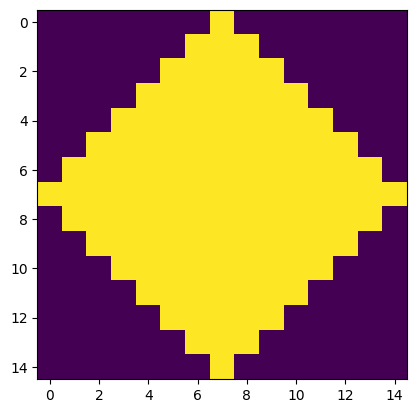

In [6]:
def star_footprint(ft, zshape):
    foo = int(np.round(zshape[0]/zshape[1]))
    footprint = np.zeros((ft, ft*foo), dtype=bool)
    for i in range( (ft-1)//2):
        s_ = np.s_[(foo*(i+1)):(foo*ft - foo*(i+1))]
        j = (ft-1)//2 - i - 1
        footprint[j, s_] = True
        footprint[-(j+1), s_] = True
    footprint[(ft-1)//2] = True
    return footprint

plt.imshow(star_footprint(15, (15,15)));

In [2]:
datafilename = os.pardir + os.sep + 'data/zscore20241104'
data = pd.read_csv(datafilename + '.csv')
zscores = data.select_dtypes(include='number')
meta = data.select_dtypes(exclude='number')
vmin = zscores.min()
vmax = zscores.max()

print(data.shape, zscores.shape, meta.shape, sep='\t')

data.head()

(2310, 157)	(2310, 156)	(2310, 1)


,Unnamed: 0,smm.1_Epidermis_seed_coat,smm.2_Epidermis_seed_coat,smm.3_Epidermis_sead_coat_SCPY,smm.4_Epidermis_seed_coat_SCHI,smm.5_Cell_cycle,smm.6_Embryo,smm.7_Cotyledon_vascular,smm.8_Cotyledon_vascular,smm.9_Vascular,os.pardir.,root.7_Cortex,root.8_Cortex,root.9_Cortex,root.10_Endodermis,root.11_Endodermis,root.12_Cambium,root.13_Pericycle,root.14_Xylem,root.15_Phloem_fiber,root.16_Phloem
0,GLYMA_01G004900_MYB,-0.089892,-0.092974,-0.060648,-0.076388,-0.101932,-0.092423,-0.111949,-0.111949,-0.070621,os.pardir.,-0.111949,-0.111949,-0.111949,-0.111949,-0.111949,-0.111949,-0.111949,-0.111949,-0.111949,-0.111949
1,GLYMA_01G005500_NAC,-0.278007,-0.141138,-0.206071,-0.209862,-0.080981,-0.271831,6.284965,0.698856,0.292240,os.pardir.,-0.145649,-0.273300,-0.281630,-0.279430,3.590243,0.141059,-0.266605,0.964809,6.681759,0.195547
2,GLYMA_01G009600_G2-like,-0.530916,-0.451082,-0.104899,0.786500,-0.442201,-0.498869,-0.269375,0.139618,-0.292579,os.pardir.,-0.424409,0.518179,0.389308,-0.022750,-0.011150,-0.126082,-0.349226,-0.319083,-0.276009,-0.016386
3,GLYMA_01G014600_HD-ZIP,-0.020174,-0.371201,-0.316552,-0.299439,-0.034733,2.161585,-0.138984,-0.265594,-0.371316,os.pardir.,-0.416940,-0.416940,-0.416940,-0.416940,-0.416940,-0.416940,-0.416940,-0.416940,-0.416940,-0.416940
4,GLYMA_01G014800_G2-like,-0.338716,0.408779,-0.340633,-0.413467,0.219349,0.930030,-0.546720,-0.422541,0.381251,os.pardir.,-0.750490,-0.627430,-0.661119,-0.005321,-0.086293,1.172313,3.723647,-0.402705,-0.796002,6.880657


In [3]:
size = 11
zthr = 5 # <- user specified: how large is large?

zmask0 = np.zeros(zscores.shape, dtype=bool)
zmask0[zscores > zthr] = True

#zmask = ndimage.grey_dilation(zmask0, size=(size,1), mode='constant', cval=vmin)
#zmask = ndimage.grey_erosion(zmask, size=(size,1), mode='constant', cval=vmax+1)
#zmask = ndimage.grey_dilation(zmask, size=(2,1), mode='constant', cval=vmin)

zmask = zmask0.copy()

label, num = ndimage.label(zmask, structure=[[0,1,0],[0,1,0],[0,1,0]])
css = ndimage.find_objects(label)
hist, bins = np.histogram(label.ravel(), bins=range(1,num+2))
print('Lit pixels: ', np.sum(zmask), '\t-->\t', num,'components')

Lit pixels:  3601 	-->	 3445 components


In [4]:
boxlims = np.array([ [s[0].start, s[0].stop, s[1].start, s[1].stop] for s in css ])
boxlims = np.column_stack((boxlims, hist))
boxes = pd.DataFrame(boxlims, columns=['top','bottom','left','right', 'size'])
boxes = boxes.sort_values(by='size', ascending=False, ignore_index=False)
boxes

,top,bottom,left,right,size
1423,944,950,44,45,6
1422,944,950,28,29,6
3324,2224,2229,28,29,5
1574,1051,1055,28,29,4
1575,1051,1055,44,45,4
os.pardir.,os.pardir.,os.pardir.,os.pardir.,os.pardir.,os.pardir.
1167,780,781,154,155,1
1168,781,782,87,88,1
1169,782,783,134,135,1
1170,782,783,135,136,1


In [5]:
htrack = np.full(len(zscores), np.nan)
keep = []

for k in range(len(boxes)):
    lims = boxes.iloc[k].values
    if np.all(np.isnan(htrack[lims[0]:lims[1]])):
        htrack[lims[0]:lims[1]] = range(lims[0], lims[1])
        keep.append(boxes.iloc[k].name)

keep = np.array(keep)
len(keep)

2125

In [6]:
bxs = boxes.loc[keep].sort_values(by='left')
argsort = np.array([], dtype=int)
for i in range(len(bxs)):
    lims = bxs.iloc[i].values
    argsort = argsort = np.hstack((argsort, range(lims[0], lims[1])))

In [7]:
redo = np.setdiff1d(range(len(zscores)), argsort)
ag = np.hstack((argsort, redo))
ag.shape

(2310,)

os.pardir/data/zscore20241104_resorted


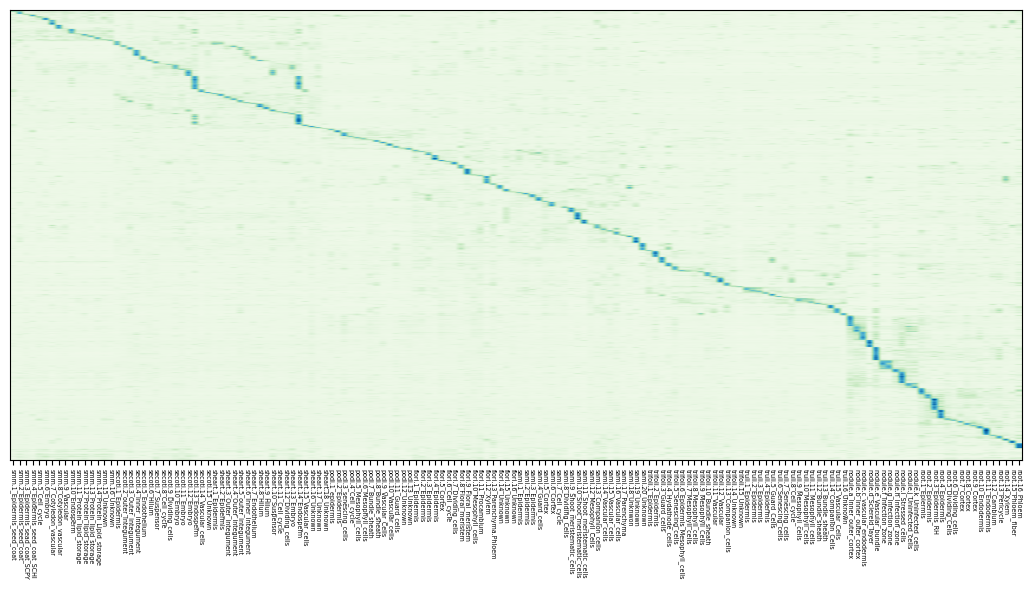

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(zscores.values[ag], cmap='GnBu')
ax[i].set_xticks(range(zscores.shape[1]), data.columns[1:], fontsize=5, rotation=270, fontstretch='ultra-condensed')
i += 1
#ax[i].imshow(zmask[ag], cmap='GnBu')

for i in range(len(ax)):
    #ax[i].axhline(len(argsort), c='r', lw=0.5)
    #ax[i].axvline(145, c='b', lw=0.5)
    #ax[i].axvline(152, c='b', lw=0.5)
    ax[i].tick_params(left=False, labelleft=False)
    ax[i].set_aspect(0.03)
    ax[i].margins(0)

fig.tight_layout();
filename = datafilename + '_resorted'
dpi = 2400
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight', dpi=dpi)
plt.savefig(filename + '.png', format='png', bbox_inches='tight', dpi=dpi)
plt.savefig(filename + '.jpg', format='jpg', bbox_inches='tight', dpi=dpi)
print(filename)

In [9]:
data.loc[ag].to_csv(filename + '.csv', index=False)